# Classifier for cluster membership

Oct 23, 2021

In [1]:
import scipy
import numpy as np
import pandas as pd
from tqdm import trange
import time

#import tensorflow.compat.v2 as tf
#tf.enable_v2_behavior()
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# data splitting and outlier removal
import  sklearn.preprocessing  # StandardScaler
from sklearn.ensemble import IsolationForest
import sklearn.model_selection #  train_test_split
import colossus
from colossus.cosmology import cosmology
# Set tensor numeric type.
dtype = 'float32'

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools # to cycle through palette colors
if 1== 1 :
  sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
  )
sns.set_palette(palette='deep')
#sns.set_palette(palette="Paired_r")
#sns_c = sns.color_palette(palette="Paired_r")
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Get TensorFlow version.
print(f'TensorFlow version: {tf.__version__}')
print(f'TensorFlow Probability version: {tfp.__version__}')

if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

2021-10-28 06:33:13.932367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/job/2.2.4-7.0.1.1_3.54__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2019.3.199/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2019.3.199/linux/mkl/lib/intel64:/usr/common/software/darshan/3.2.1/lib
2021-10-28 06:33:13.932386: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0-dev20211012
TensorFlow Probability version: 0.15.0-dev20211013


2021-10-28 06:33:31.162628: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-28 06:33:31.222736: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-28 06:33:31.222756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nid00575): /proc/driver/nvidia/version does not exist


In [2]:
def write_galaxy_sample (gal_df) :
    # model photo-z as a gaussian of sigma=0.03
    z = gal_df["redshift"]
    pz = z+np.random.normal(0,0.03, size=z.size)
    # if the pz < 0, flip it about 0
    ix, = np.where(pz<0)
    pz[ix] = np.abs(pz[ix])
    is_central = gal_df["is_central"]
    cl_id = gal_df["cluster_id"] 
    halo_id = gal_df["halo_id"]
    # set the central galaxies to no pz error
    ix = ((is_central==True) & (cl_id == halo_id))
    pz[ix] = z[ix]
    delta_pz = pz - gal_df["cluster_z"]

    print("sm")
    cosmos=cosmology.setCosmology('planck18')
    luminosityDistance_gal = cosmos.luminosityDistance(pz)
    luminosityDistance_cl = cosmos.luminosityDistance(gal_df["cluster_z"])
    delta_dm = 5*np.log10(luminosityDistance_gal/luminosityDistance_cl)
    gal_smass = gal_df["stellar_mass"] - delta_dm

    print("radius")
    angularDiameterDistance = cosmos.angularDiameterDistance(gal_df["cluster_z"])
    degrees_per_mpc = (1./angularDiameterDistance)*(360./2/np.pi)
    cluster_radius_mpc = gal_df["cluster_radius_arcmin"]/60./degrees_per_mpc

    print("prep galaxies")
    galaxies = pd.DataFrame({})
    galaxies["radius"] = cluster_radius_mpc
    galaxies["delta-pz"] = delta_pz
    galaxies["stellarmass"]= gal_smass
    galaxies["cl_z"] = gal_df["cluster_z"]
    galaxies["i_mag"]=gal_df["mag_i"]
    galaxies["u-g"] = gal_df["mag_u-g"]
    galaxies["g-r"] = gal_df["mag_g-r"]
    galaxies["r-i"] = gal_df["mag_r-i"]
    galaxies["i-z"] = gal_df["mag_i-z"]
    cluster_member = (gal_df["halo_id"] == gal_df["cluster_id"])
    cluster_member = np.array(cluster_member).astype("int")
    galaxies["member"] = cluster_member
    galaxies["id"] = galaxies.index


    print("starting to write")
    galaxies.to_csv("~/Data/galaxies_near_clusters_small.csv")
    print("wrote ~/Data/galaxies_near_clusters_small.csv   {} gals".format(galaxies["radius"].size))

    gal_df = pd.read_csv("~/Data/galaxies_near_clusters_0.3-0.6.csv", index_col=0)
need_to_generate = False
if need_to_generate:
    print(gal_df.head())
    write_galaxy_sample (gal_df)
    
galaxies = pd.read_csv("~/Data/galaxies_near_clusters_small.csv", index_col=0)
print(galaxies.head())
#

     radius  delta-pz  stellarmass      cl_z      i_mag       u-g       g-r  \
0  1.390108 -0.296234    14.101338  0.377169  16.710154  1.717278  0.932936   
1  0.316237 -0.191917    12.542130  0.377169  17.553968  1.706240  1.123459   
2  0.288371 -0.175732    11.345499  0.377169  19.848861  1.695599  1.063702   
3  0.275092 -0.258053    12.671572  0.377169  19.362929  1.733788  1.121321   
4  1.672411 -0.181209    11.965657  0.377169  18.689300  1.673197  1.098970   

        r-i       i-z  member  id  
0  0.455732  0.321991       0   0  
1  0.494001  0.287647       0   1  
2  0.464962  0.269772       0   2  
3  0.481617  0.299284       0   3  
4  0.491835  0.312542       0   4  


In [3]:
train,test = sklearn.model_selection.train_test_split(galaxies, train_size=0.80)
#X_t = sklearn.preprocessing.StandardScaler.fit_transform(train)
X = train[train.columns[:-2]]
y = train[train.columns[-2]]
print("X, y:", X.shape, y.shape)
X_test = test[test.columns[:-2]]
y_test = test[test.columns[-2]]



train = tf.data.Dataset.from_tensor_slices( (X, y)).shuffle(10000).batch(1000)

all_X = galaxies[galaxies.columns[:-2]]
all_y = galaxies[galaxies.columns[-2]]


X, y: (229314, 9) (229314,)


In [4]:
# Note that when using the delayed-build pattern (no input shape specified),
# the model gets built the first time you call `fit`, `eval`, or `predict`,
# or the first time you call the model on some input data.
model = tf.keras.Sequential()
#model.add(tf.keras.layers.Dense(64,activation='relu', input_dim=9))
#model.add(tf.keras.layers.Dense(32,activation='relu'))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dense(8,activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))


start = time.time()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
doRun = False
if doRun == True:
    model.fit(X,y, epochs=10)
    #model.fit(X,y, epochs=100)
    end = time.time()
    print("optimizing time: {:2f} seconds".format(end - start))

    print(model.summary())
    score = model.evaluate(X_test, y_test, verbose=1)

    print("Test Score:", score[0])
    print("Test Accuracy: {:.2f}%".format(score[1]*100))



In [5]:
Saved_Model_Name = '~/Models/cluster_membership-100e'
#model.save(Saved_Model_Name)
model = tf.keras.models.load_model(Saved_Model_Name)

membership = np.squeeze(model.predict(all_X))
membership.shape, all_X.shape, all_y.shape

((286643,), (286643, 9), (286643,))

In [6]:
gal_df = pd.read_csv("~/Data/galaxies_near_clusters_0.3-0.6.csv", index_col=0)
cluster_data = pd.read_csv("~/Data/cluster_data_0.3-0.6.csv")
cluster_data.head()

,Unnamed: 0,dec,ra,redshift,halo_mass,stellar_mass,halo_id,central_sm,sm_0.50,sm_0.67,sm_1.0,sm_1.5,sm_2.0,sm_3.0,stellarmass
0,0,-39.595058,61.754715,0.377169,14.658120,1.305021e+12,268600155355,12.115618,12.476259,12.515145,12.572289,12.584593,12.584593,12.584593,12.584593
1,1,-41.089805,62.125393,0.385860,14.089678,7.850036e+11,397200155355,11.894872,11.958520,11.985133,11.995679,11.995679,11.995679,11.995679,11.995679
2,2,-39.809490,62.668306,0.374379,14.383239,5.800606e+11,449800155355,11.763473,12.158964,12.191358,12.205451,12.217457,12.218066,12.218066,12.218066
3,3,-41.168704,61.504270,0.377054,14.287383,6.616984e+11,562900155355,11.820660,12.242907,12.271576,12.326310,12.339697,12.339697,12.339697,12.339697
4,4,-41.012162,61.380974,0.435655,14.141557,4.252299e+11,467800155338,11.628624,11.994025,12.073444,12.181086,12.181086,12.181086,12.181086,12.181086


In [58]:
print("highest mass cluster:   ",np.argmax(cluster_data["halo_mass"]))
z=cluster_data.iloc[251]; print (z["halo_id"].astype("int"))

galaxies["memb_prob"] = membership
zz = gal_df[gal_df["cluster_id"]==79700142331]; 
zz_id = zz.index
zg=galaxies[galaxies["id"].isin(zz_id)]  # vector instead of scalar or matching length
print(zz.shape, zg.shape, zz_id.shape, np.unique(zz_id).shape)

highest mass cluster:    251
79700142331
(1050, 15) (1050, 12) (1050,) (1050,)


In [16]:
sm = (zg["memb_prob"]*zg["member"]*10**(zg["stellarmass"])).sum(); 
sm = np.log10(sm); print("if member, sum(memb_prob*sm):  ",sm, z["stellarmass"])

if member, sum(memb_prob*sm):   12.550940794848632 12.647303


In [117]:
print(cluster_data.head(), "\n\nstellar_mass is central galaxy, stellarmass is the total cluster stellar mass")

   Unnamed: 0        dec         ra  redshift  halo_mass  stellar_mass  \
0           0 -39.595058  61.754715  0.377169  14.658120  1.305021e+12   
1           1 -41.089805  62.125393  0.385860  14.089678  7.850036e+11   
2           2 -39.809490  62.668306  0.374379  14.383239  5.800606e+11   
3           3 -41.168704  61.504270  0.377054  14.287383  6.616984e+11   
4           4 -41.012162  61.380974  0.435655  14.141557  4.252299e+11   

        halo_id  central_sm    sm_0.50    sm_0.67     sm_1.0     sm_1.5  \
0  268600155355   12.115618  12.476259  12.515145  12.572289  12.584593   
1  397200155355   11.894872  11.958520  11.985133  11.995679  11.995679   
2  449800155355   11.763473  12.158964  12.191358  12.205451  12.217457   
3  562900155355   11.820660  12.242907  12.271576  12.326310  12.339697   
4  467800155338   11.628624  11.994025  12.073444  12.181086  12.181086   

      sm_2.0     sm_3.0  stellarmass  
0  12.584593  12.584593    12.584593  
1  11.995679  11.995679   

In [17]:
gal_df.shape, cluster_data.shape
print(galaxies.head())

     radius  delta-pz  stellarmass      cl_z      i_mag       u-g       g-r  \
0  1.390108 -0.296234    14.101338  0.377169  16.710154  1.717278  0.932936   
1  0.316237 -0.191917    12.542130  0.377169  17.553968  1.706240  1.123459   
2  0.288371 -0.175732    11.345499  0.377169  19.848861  1.695599  1.063702   
3  0.275092 -0.258053    12.671572  0.377169  19.362929  1.733788  1.121321   
4  1.672411 -0.181209    11.965657  0.377169  18.689300  1.673197  1.098970   

        r-i       i-z  member  id     memb_prob  
0  0.455732  0.321991       0   0  4.371683e-36  
1  0.494001  0.287647       0   1  1.093713e-08  
2  0.464962  0.269772       0   2  3.830897e-07  
3  0.481617  0.299284       0   3  5.023689e-11  
4  0.491835  0.312542       0   4  9.455622e-21  


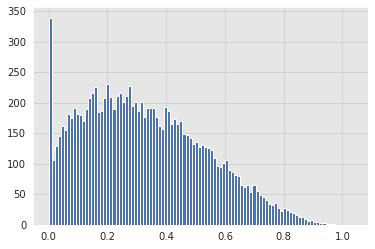

In [7]:
galaxies["memb_prob"] = membership
cnt,bins,junk=plt.hist(galaxies[galaxies["memb_prob"]>0.1]["radius"], bins=100, weights=membership[membership>0.1])

/tmp/ipykernel_44342/2722077194.py:36: RuntimeWarning: invalid value encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1])
/tmp/ipykernel_44342/2722077194.py:36: RuntimeWarning: invalid value encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1])
/tmp/ipykernel_44342/2722077194.py:36: RuntimeWarning: invalid value encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1])
/tmp/ipykernel_44342/2722077194.py:36: RuntimeWarning: invalid value encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1])
/tmp/ipykernel_44342/2722077194.py:40: RuntimeWarning: divide by zero encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1], color="k")
/tmp/ipykernel_44342/2722077194.py:40: RuntimeWarning: invalid value encountered in true_divide
  sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1], color="k")


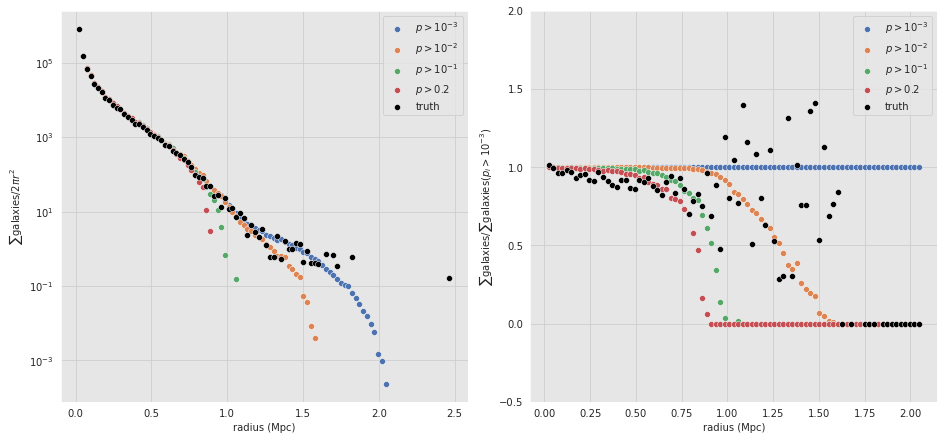

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), constrained_layout=True)
axes[0].set_yscale("log")

lim_prob = 1e-3
inside = galaxies[galaxies["memb_prob"]>lim_prob]
weights = membership[membership>lim_prob]
cnt,bins=np.histogram(inside["radius"], bins=bins, weights=weights)

for lim_prob in [1e-3, 1e-2, 0.1, 0.2]:
    inside = galaxies[galaxies["memb_prob"]>lim_prob]
    weights = membership[membership>lim_prob]#*inside["member"] # membership_prob * member is the best performance
    cnt,abins=np.histogram(inside["radius"], bins=bins, weights=weights)
    sns.scatterplot(x=bins[1:], y=cnt/(bins[1:]**2), ax=axes[0])
    
inside = galaxies[galaxies["member"]==1]
cnt,bins=np.histogram(inside["radius"], bins=100)
#sns.lineplot(x=bins[1:], y=cnt/(bins[1:]**2), color="k",  ax=axes[0])
sns.scatterplot(x=bins[1:], y=cnt/(bins[1:]**2), ax=axes[0], color="k")
axes[0].set_xlabel("radius (Mpc)")
axes[0].set_ylabel(r"$\sum$galaxies$/2\pi r^2$")
axes[0].legend(labels=[r"$p>10^{-3}$",r"$p>10^{-2}$",r"$p>10^{-1}$",r"$p>0.2$", "truth"])

# inside = galaxies[galaxies["member"]==1]
# acnt,bins=np.histogram(inside["radius"], bins=100)

lim_prob = 1e-3
inside = galaxies[galaxies["memb_prob"]>lim_prob]
weights = membership[membership>lim_prob]
acnt,bins=np.histogram(inside["radius"], bins=bins, weights=weights)

for lim_prob in [1e-3, 1e-2, 0.1, 0.2]:

    inside = galaxies[galaxies["memb_prob"]>lim_prob]
    weights = membership[membership>lim_prob]#*inside["member"] # membership_prob * member is the best performance
    cnt,xbins=np.histogram(inside["radius"], bins=bins, weights=weights)
    sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1])
    
inside = galaxies[galaxies["member"]==1]
cnt,bins=np.histogram(inside["radius"], bins=100)
sns.scatterplot(x=bins[1:], y=cnt/acnt, ax=axes[1], color="k")
axes[1].set_ylim(-0.5,2.0)
    
axes[1].set_xlabel("radius (Mpc)")
axes[1].set_ylabel(r"$\sum$galaxies$/\sum$galaxies$(p_i>10^{-3})$")
axes[1].legend(labels=[r"$p>10^{-3}$",r"$p>10^{-2}$",r"$p>10^{-1}$",r"$p>0.2$", "truth"])
#plt.savefig("radial_profile.png")

#

In [8]:
#gal_df = pd.read_csv("~/Data/galaxies_near_clusters_0.3-0.6.csv", index_col=0)
galaxies["memb_prob"] = membership

list_sm = []; list_rsm = []
for hid,sm in zip(cluster_data["halo_id"], cluster_data["stellarmass"]) :
#print("===================== truth is sm_1.0 stellar mass within 1 mpc ===============")
#for hid,sm in zip(cluster_data["halo_id"], cluster_data["sm_1.0"]) :


    this = gal_df[gal_df["cluster_id"]==hid]
    these = galaxies[galaxies["id"].isin(this.index)]
    
    these = these[these["radius"]<= 0.67]
    
    # sum(memb_prob*sm)
    recovered_sm = (these["memb_prob"]*10**(these["stellarmass"])).sum()
    # sum(sm):
    #recovered_sm = (10**(these["stellarmass"])).sum()
    
    recovered_sm = np.log10(recovered_sm)
    #print("hid total_sm recovered_sm delta: {:d} {:.2f} {:.2f} {:.2f}".format(hid, sm, recovered_sm, sm-recovered_sm))
    list_sm.append(sm)
    list_rsm.append(recovered_sm)
sm = np.array(list_sm)
rsm = np.array(list_rsm)


In [9]:
cluster_data["measured_sm"]=rsm
#cluster_data= cluster_data.drop(columns="stellar_mass")
#cluster_data= cluster_data.drop(columns="Unnamed: 0")
print(cluster_data.head())
# stellar_mass comes with the is_central selection- it is the central galaxy stellar mass
# central_sm = stellar_mass then drop(stellar_mass) but it is stll there!
#cluster_data.to_csv("~/Data/cluster_data_0.3-0.6-msm.csv")

#

   Unnamed: 0        dec         ra  redshift  halo_mass  stellar_mass  \
0           0 -39.595058  61.754715  0.377169  14.658120  1.305021e+12   
1           1 -41.089805  62.125393  0.385860  14.089678  7.850036e+11   
2           2 -39.809490  62.668306  0.374379  14.383239  5.800606e+11   
3           3 -41.168704  61.504270  0.377054  14.287383  6.616984e+11   
4           4 -41.012162  61.380974  0.435655  14.141557  4.252299e+11   

        halo_id  central_sm    sm_0.50    sm_0.67     sm_1.0     sm_1.5  \
0  268600155355   12.115618  12.476259  12.515145  12.572289  12.584593   
1  397200155355   11.894872  11.958520  11.985133  11.995679  11.995679   
2  449800155355   11.763473  12.158964  12.191358  12.205451  12.217457   
3  562900155355   11.820660  12.242907  12.271576  12.326310  12.339697   
4  467800155338   11.628624  11.994025  12.073444  12.181086  12.181086   

      sm_2.0     sm_3.0  stellarmass  measured_sm  
0  12.584593  12.584593    12.584593    12.491581  


mean and std: 0.04 0.09


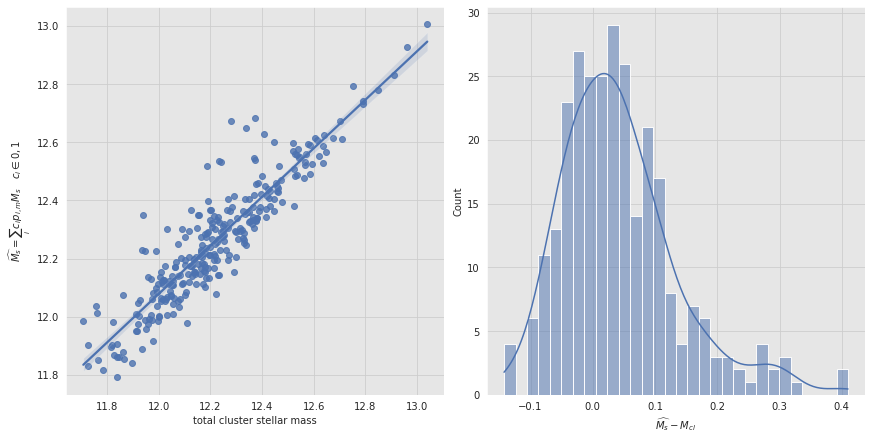

In [23]:
#ix = (sm-rsm) < -1.0
#print("outlier number: ", sm[ix].shape)
#ix = (sm-rsm) > -1.0
#print("keep number: ", sm[ix].shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
sns.regplot(x=sm,y=rsm, ax=axes[0])
axes[0].set_xlabel("total cluster stellar mass");axes[0].set_ylabel(r"$\widehat{M_s} = \sum_i c_i p_{i,m} M_s \quad c_i \in {0,1}$")

delta = (rsm-sm)
sns.histplot(delta, kde=True, bins=30, ax=axes[1])
axes[1].set_xlabel("$ \widehat{M_s} - M_{cl}$ ");#axes[1].set_ylabel(r"$\widehat{M_s} = \sum_i c_i p_{i,m} M_s \quad c_i \in {0,1}$")


print("mean and std: {:.2f} {:.2f}".format(delta.mean(), delta.std()))

# would love to try Geosciences' sinh-arcsinh distribution
doSkewNorm=False
if doSkewNorm:
    a, loc, scale= scipy.stats.skewnorm.fit(delta); 
    print(loc, scale, a)
    rv = scipy.stats.skewnorm(loc=loc, scale=scale,a=a)
    x=np.arange(-0.10,0.15,0.01)
    axes.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
    print("skewnorm is a lousy fit")
#plt.savefig("stellar_mass.png")

In [34]:
id = np.argmin(sm-rsm)

z=cluster_data.iloc[id]; 
print (z["halo_id"].astype("int"))
print("halo mass cluster:   ",z["halo_mass"])

zz = gal_df[gal_df["cluster_id"]==z["halo_id"].astype("int")]; 
zz_id = zz.index
zg=galaxies[galaxies["id"].isin(zz_id)]  # vector instead of scalar or matching length
zg = zg[zg["memb_prob"]>1e-3]

tsm = (zg["memb_prob"]*10**(zg["stellarmass"])).sum(); tsm = np.log10(tsm); 
print("sum(memb_prob*sm):  ", tsm, z["stellarmass"])

tsm = (10**(zg["stellarmass"])).sum(); tsm = np.log10(tsm); 
print("sum(sm):  ",tsm, z["stellarmass"])

#tsm = (zg["memb_prob"]*zg["member"]*10**(zg["stellarmass"])).sum(); tsm = np.log10(tsm); 
#print("if member, sum(memb_prob*sm):  ",tsm, z["stellarmass"])

517600143355
halo mass cluster:    14.155895111789272
sum(memb_prob*sm):   12.4165664674396 11.938973
sum(sm):   12.985245058030278 11.938973


In [10]:
rdf=pd.DataFrame({"rsm":rsm,"sm":sm})
rsm_train,rsm_test = sklearn.model_selection.train_test_split(rdf, train_size=0.80)

Xsm_train = rsm_train[rsm_train.columns[:-1]]
ysm_train  = rsm_train[rsm_train.columns[-1]]
print("X, y:", X.shape, y.shape)
Xsm_test = rsm_test[rsm_test.columns[:-1]]
ysm_test = rsm_test[rsm_test.columns[-1]]
#sm_train = tf.data.Dataset.from_tensor_slices( (Xsm, ysm))#.shuffle(10000).batch(1000)

Xsm_train = tf.squeeze(Xsm_train)
ysm_train = tf.squeeze(ysm_train)
Xsm_test = tf.squeeze(Xsm_test)
ysm_test = tf.squeeze(ysm_test)
print(Xsm_train.shape, ysm_train.shape)
print((Xsm_train-ysm_train).shape)

#rsm=np.squeeze(rsm); sm=np.squeeze(sm); print(rsm.shape,sm.shape)

X, y: (229314, 9) (229314,)
(229,) (229,)
(229,)


In [70]:
# this code, the tfp.distributions.SinhArcsinh, seems buggy

negloglik = lambda y, rv_y: -rv_y.log_prob(y)
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8),
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(
#      lambda t: tfp.distributions.SinhArcsinh(loc=t[..., :1],  #scale=0.018)),
#                scale=t[..., 1:], skewness=t[..., :1])), #tailweight=1.0)),
      lambda t: tfp.distributions.LogNormal(loc=t[..., :1],  scale=t[..., 1:], ))
])

start = time.time()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(Xsm, ysm, epochs=1000, verbose=False)
end = time.time()
print("\n\n===============")
print("optimizing time: {:2f} seconds".format(end - start))

print(model.summary())



optimizing time: 11.099762 seconds
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 16        
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
 distribution_lambda_16 (Dis  ((None, None),           0         
 tributionLambda)             (None, None))                      
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________
None


In [14]:

from tensorflow.keras.initializers import RandomNormal , Zeros

INPUT_SHAPE = 1 
N_HIDDENS = 10 
N_HIDDENS = 2
SEED = 99


# Loss function

def RegressLossExpSigma(y_true , y_pred): 
    mu = y_pred[:, 0]
    std = tf.math.exp(y_pred[:, 1]) 
    skew = y_pred[:, 2]
    tau = tf.math.exp(y_pred[:, 3])
    #tau = 1.0
    cond_dist = tfp.distributions.SinhArcsinh(loc=mu, scale=std, skewness=skew, tailweight=tau)
    loss = -cond_dist.log_prob(y_true[:, 0])
    return tf.reduce_mean(loss, axis=-1)

inputs = tf.keras.Input(shape=INPUT_SHAPE) 
x = inputs
# initialize a single hidden layer
x = tf.keras.layers.Dense(
    N_HIDDENS,
    #activation="relu",
    activation="linear",
    use_bias=True,
    bias_initializer=RandomNormal(seed=SEED),
    kernel_initializer=RandomNormal(seed=SEED),
)(x)


# set final output units separately
mu_unit = tf.keras.layers.Dense( 
    1,
    activation="linear",
    use_bias=True, 
    bias_initializer=RandomNormal(seed=SEED), 
    kernel_initializer=RandomNormal(seed=SEED),
)(x)

logsigma_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

skew_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

logtau_unit = tf.keras.layers.Dense( 
    1,
    activation="linear", 
    use_bias=True, 
    bias_initializer=Zeros(), 
    kernel_initializer=Zeros(),
)(x)

output_layer = tf.keras.layers.concatenate([mu_unit , logsigma_unit , skew_unit , logtau_unit], axis=1)
#output_layer =  tf.keras.layers.concatenate([mu_unit , logsigma_unit , skew_unit ] , axis=1)

model = tf.keras.Model(inputs=inputs, outputs=output_layer)

start = time.time()
model.compile(loss=RegressLossExpSigma, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model.fit(Xsm_train,ysm_train, epochs=5000, verbose=0)
#model.fit(rsm,sm, epochs=1000, verbose=0)
end = time.time()
print("\n\n===============")
print("optimizing time: {:2f} seconds".format(end - start))

print(model.summary())




optimizing time: 49.846210 seconds
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 2)            4           ['input_2[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 1)            3           ['dense_8[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 1)            3           ['dense_8[0][0]']                
                                                       

In [15]:
prediction = np.squeeze(model.predict(Xsm_test))
prediction.view()

array([[12.163018  , -2.4471545 , -0.36138642,  0.22157265],
       [12.318361  , -2.4727528 , -0.36346447,  0.22071113],
       [12.321059  , -2.4731975 , -0.3635006 ,  0.22069615],
       [12.375116  , -2.4821053 , -0.36422372,  0.22039635],
       [12.071255  , -2.432033  , -0.36015883,  0.22208157],
       [12.130576  , -2.4418082 , -0.36095238,  0.22175258],
       [12.555396  , -2.5118127 , -0.3666354 ,  0.21939653],
       [12.452327  , -2.4948285 , -0.3652566 ,  0.21996814],
       [12.479644  , -2.4993298 , -0.36562204,  0.21981664],
       [12.611098  , -2.5209918 , -0.36738056,  0.2190876 ],
       [12.159301  , -2.4465418 , -0.36133665,  0.22159328],
       [12.2248125 , -2.4573371 , -0.36221305,  0.22122994],
       [12.508311  , -2.5040536 , -0.36600554,  0.21965767],
       [12.078032  , -2.4331496 , -0.3602495 ,  0.22204399],
       [12.138914  , -2.4431822 , -0.36106396,  0.22170633],
       [12.386006  , -2.4838998 , -0.36436942,  0.22033596],
       [12.321761  , -2.

In [26]:

prediction = np.squeeze(model.predict(Xsm_test))
print("model shape:", prediction.shape)
pre=tf.math.reduce_mean(prediction, axis=0)
print("model shape:", pre.shape)
p=pre.numpy()

mu=p[0]; sigma=p[1]; skew=p[2]; tau=np.log(1); 
tau = p[3]; 
print(mu,sigma,skew,tau)
sigma=np.e**sigma; tau = np.e**tau

mu=mu.astype(dtype); sigma=sigma.astype(dtype); skew=skew.astype(dtype); #tau=tau.astype(dtype)
print(mu,sigma,skew,tau)

model shape: (58, 4)
model shape: (4,)
11.997697 -2.2834234 1.4102448 -3.1064394
11.997697 0.10193464 1.4102448 0.04476004670721374


In [102]:
print("last run",mu,sigma,skew,tau)
print("close to truth",12.2,0.018,0.22,1.0)

last run 12.249814 0.052280948 -0.09369159 1.0
close to truth 12.2 0.018 0.22 1.0


In [41]:
prediction = np.squeeze(model.predict(rsm))
print("prediction:", prediction.shape)
#prediction = tf.math.reduce_mean(prediction, axis=0)
#print("prediction:", prediction.shape)
#prediction.view()
p= prediction
print(p[:,0].mean(), p[:,0].std())
print((np.e**p[:,1]).mean(), (np.e**p[:,1]).std())
print(p[:,2].mean(), p[:,2].std())

prediction: (287, 3)
12.280855 0.19809134
0.09241999 0.0035701615
-0.45980963 0.0082704285


samp: (1000, 287)
samp: (287, 1000)
mean and std: 0.04 0.09
prediction: (287, 4)
prediction: (4,)
prediction mean loc, scale, skew:  12.28 -0.08 -0.36 1.25


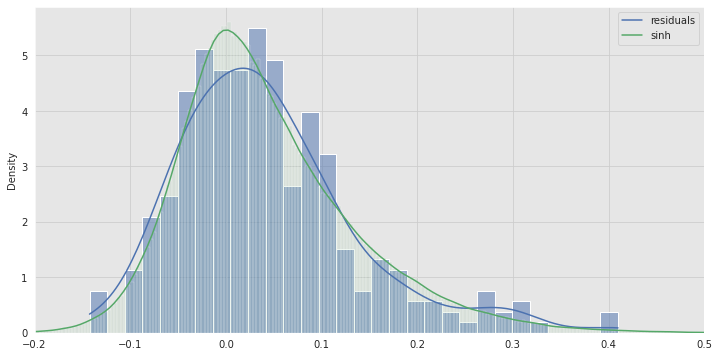

In [25]:
prediction = np.squeeze(model.predict(rsm))         # just do the whole sample
# print(prediction.view())

sa_dist = tfp.distributions.SinhArcsinh(  0,
    tf.math.pow(np.e,prediction[:,1]), 
    skewness=-1*prediction[:,2],tailweight= tf.math.pow(np.e,prediction[:,3]))

samp = sa_dist.sample(tf.constant(1000))
print("samp:", samp.shape)
samp = tf.transpose(samp)
print("samp:", samp.shape)

delta = (rsm-sm)                 # just do the whole sample
#print(delta)


accum = np.array([])
for i in np.arange(samp.shape[1]).astype(int):
    s=samp[:,i].numpy()
    accum = np.concatenate([accum, s])
samp = accum

if 1 == 1:
    palette = itertools.cycle(sns.color_palette())
    # color
    c = next(palette); 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

    #axes.legend(loc='upper right')
    sns.histplot(delta, kde=True,color=c, legend=True,stat="density", bins=30)
    c = next(palette); c = next(palette); #c = next(palette); 

    print("mean and std: {:.2f} {:.2f}".format(delta.mean(), delta.std()))
    # would love to try Geosciences' sinh-arcsinh distribution
    #sns.histplot(samp, kde=True, color=c, legend=True, stat="density", bins=18, alpha=0.1)
    sns.histplot(samp, kde=True, color=c, legend=True, stat="density", alpha=0.1)
    plt.legend(labels=["residuals","sinh"])
    axes.set_xlim(-0.2,0.5)

prediction = np.squeeze(model.predict(rsm))
print("prediction:", prediction.shape)
prediction = tf.math.reduce_mean(prediction, axis=0)
print("prediction:", prediction.shape)
#prediction.view()

prediction=prediction.numpy()
print ("prediction mean loc, scale, skew:  {:.2f} {:.2f} {:.2f} {:.2f}".format(
    prediction[0], -1*np.e**prediction[1], prediction[2],np.e**prediction[3], ))


doSkewNorm = False
if doSkewNorm: 
    x_sigma = 10*np.e**prediction[1]
    xrange = np.arange( prediction[0]-x_sigma-12, prediction[0]+x_sigma-12,x_sigma/100.)

    a, loc, scale= scipy.stats.skewnorm.fit(delta); 
    rv = scipy.stats.skewnorm(loc=loc, scale=scale,a=a)
    print ("skewnorm  loc, scale, skew:  {:.2f} {:.2f} {:.2f} ".format(loc, scale, a))


    a, loc, scale= scipy.stats.skewnorm.fit(delta); 
    rv = scipy.stats.skewnorm(loc=loc, scale=scale,a=a)
    c = next(palette)
    axes.plot(xrange, rv.pdf(xrange), lw=2, label='frozen pdf',color=c)

doNorm = False
if doNorm: 
    loc, scale= scipy.stats.norm.fit(delta); 
    rv = scipy.stats.norm(loc=loc, scale=scale)
    c = next(palette)
    axes.plot(xrange, rv.pdf(xrange), lw=2, label='frozen pdf',color="k")
    print(loc, scale)

###### 

In [9]:
# bin 0.2-0.3, 0.3-0.4, 0.4-0.6 0.6-0.7
cosmos=cosmology.setCosmology('planck18')
for z in [0.25, 0.35, 0.5, 0.65]  :
    angularDiameterDistance = cosmos.angularDiameterDistance(z)
    degrees_per_mpc = (1./angularDiameterDistance)*(360./2/np.pi)
    print(z, degrees_per_mpc, 60*degrees_per_mpc)
    
    #

0.25 0.10169642060280862 6.101785236168517
0.35 0.08055941037740304 4.833564622644182
0.5 0.06526093212786645 3.915655927671987
0.65 0.0575450718947132 3.452704313682792


In [12]:
# bin 0.2-0.3, 0.3-0.4, 0.4-0.6 0.6-0.7
for z in np.arange(0,1,0.05):
    if z <0.3:
        print("{:4.2f} {:4.2f}:    {:4.1f}".format( z, 0.25, 6.1))
    elif ( (z>= 0.3) & (z< 0.4)) :
        print("{:4.2f} {:4.2f}:    {:4.1f}".format( z, 0.35, 4.8))
    elif ( (z>= 0.4) & (z< 0.6)) :
        print("{:4.2f} {:4.2f}:    {:4.1f}".format( z, 0.5, 3.9))
    elif z>= 0.6 :
        print("{:4.2f} {:4.2f}:    {:4.1f}".format( z, 0.65, 3.5))


0.00 0.25:     6.1
0.05 0.25:     6.1
0.10 0.25:     6.1
0.15 0.25:     6.1
0.20 0.25:     6.1
0.25 0.25:     6.1
0.30 0.35:     4.8
0.35 0.35:     4.8
0.40 0.50:     3.9
0.45 0.50:     3.9
0.50 0.50:     3.9
0.55 0.50:     3.9
0.60 0.65:     3.5
0.65 0.65:     3.5
0.70 0.65:     3.5
0.75 0.65:     3.5
0.80 0.65:     3.5
0.85 0.65:     3.5
0.90 0.65:     3.5
0.95 0.65:     3.5
